# Online Shopping Behaviour - Tjark Petersen

In [43]:
import types
import pandas as pd
import numpy as np
from botocore.client import Config
import ibm_boto3

import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

from watson_machine_learning_client import WatsonMachineLearningAPIClient
# import pickle

# ETL

In [2]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_3b08f636aa4c4bc58b03e36105622462 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='EI06iPS11MRoHQiLAPwMFIukCpW_Yx5PqbVhI0FSYqjZ',
    ibm_auth_endpoint="https://iam.eu-de.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_3b08f636aa4c4bc58b03e36105622462.get_object(Bucket='courserabadges-donotdelete-pr-72y9f6bzbckngj',Key='online_shoppers_intention.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [4]:
# delete missing values and delete the duration -1 cases
print(df[df.Administrative_Duration == -1].index)
print(df[df.Informational_Duration == -1].index)
print(df[df.ProductRelated_Duration == -1].index)

Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')
Int64Index([   2,    6,    7,   16,   21,   24,   49,   50,   64,  132,  140,
             181,  182,  252,  383,  532,  540,  562,  591,  638, 2046, 2052,
            2061, 4799, 4915, 5095, 5096, 5107, 5124, 6260, 7210, 8052, 8636],
           dtype='int64')


In [5]:
# delete these 33 cases 
df = df[df.Administrative_Duration != -1]

In [6]:
# delete rows with any missing values
print('before: ', df.isnull().sum().sum())
df = df.dropna(how='any',axis=0)
print('afterwards: ', df.isnull().sum().sum())

before:  112
afterwards:  0


In [7]:
# change target from boolean to 0/1:
df['Revenue'] = df['Revenue'].apply(lambda x: 1 if (x is True) else 0)

In [8]:
df.head(3)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,0
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,0
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,0


In [9]:
# store the etl data
csv_body = df.to_csv(sep=',', encoding='UTF-8', index=False)
meta_data = client_3b08f636aa4c4bc58b03e36105622462.put_object(Body=csv_body, Bucket='courserabadges-donotdelete-pr-72y9f6bzbckngj',Key='shopping_behaviour.etl.csv')

# Feature Engineering

In [10]:
# load etl data if necessary
'''
body = client_3b08f636aa4c4bc58b03e36105622462.get_object(Bucket='courserabadges-donotdelete-pr-72y9f6bzbckngj',Key='online_shoppers_intention_etl.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )
df = pd.read_csv(body)
df.head()
'''

'\nbody = client_3b08f636aa4c4bc58b03e36105622462.get_object(Bucket=\'courserabadges-donotdelete-pr-72y9f6bzbckngj\',Key=\'online_shoppers_intention_etl.csv\')[\'Body\']\n# add missing __iter__ method, so pandas accepts body as file-like object\nif not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )\ndf = pd.read_csv(body)\ndf.head()\n'

In [11]:
# split the data
X=df.iloc[:,:-1]
y=df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [48]:
# FeatureSelector & FeatureUnion not used because of errors with the WatsonML deployment, instead I used the ColumnTransfornmer
class FeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, columns):
        self.name = 'select columns'
        self.columns = columns
    
    def fit( self, X, y = None ):
        return self 
    
    def transform(self, X, y = None):
        return X[self.columns] 

class NumericalTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'numerical features'
        
    def feature_transform(self, df, func, add, columns=None):
        if columns is not None:
            df_temp = df[columns].astype('float64')
        else:
            df_temp = df.astype('float64')
        df_transformed = pd.DataFrame(df_temp.apply(lambda x: func(x+add)), columns = df_temp.columns)
        # df = df.drop(columns=columns)
        # df = pd.concat([df_transformed, df], axis=1)
        return df_transformed.values
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.feature_transform(df=X, func=np.log, add=1)
        # print('num features', X.shape)
        return X
    
    
'''
class InteractionTransformer(BaseEstimator, TransformerMixin):

    def __init__( self):
        self.name = 'interactions of numerical features'
        
    def add_interaction(self, df, col_1, col_2):
        df['interaction'] = df[col_1] * df[col_2]
        return df
        
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        X = self.add_interaction(df=X, col_1='Administrative', col_2='PageValues')
        # print('num features', X.shape)
        return X.values
    
class CategoricalTransformer(BaseEstimator, TransformerMixin):
    
    def __init__( self):
        self.name = 'categorical features'
    
    def fit(self, X, y = None):
        return self 

    def transform(self, X, y = None):
        # X = self.get_binary_weekend(df=X)
        # print('cat features', X.shape)
        # return X.values
        return self
'''

"\nclass InteractionTransformer(BaseEstimator, TransformerMixin):\n\n    def __init__( self):\n        self.name = 'interactions of numerical features'\n        \n    def add_interaction(self, df, col_1, col_2):\n        df['interaction'] = df[col_1] * df[col_2]\n        return df\n        \n    def fit(self, X, y = None):\n        return self \n\n    def transform(self, X, y = None):\n        X = self.add_interaction(df=X, col_1='Administrative', col_2='PageValues')\n        # print('num features', X.shape)\n        return X.values\n    \nclass CategoricalTransformer(BaseEstimator, TransformerMixin):\n    \n    def __init__( self):\n        self.name = 'categorical features'\n    \n    def fit(self, X, y = None):\n        return self \n\n    def transform(self, X, y = None):\n        # X = self.get_binary_weekend(df=X)\n        # print('cat features', X.shape)\n        # return X.values\n        return self\n"

In [13]:
cat_cols = ['Month', 'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend']
num_cols = ['Administrative',
             'Administrative_Duration',
             'Informational',
             'Informational_Duration',
             'ProductRelated',
             'ProductRelated_Duration',
             'BounceRates',
             'ExitRates',
             'PageValues',
             'SpecialDay']

#( 'cat_transformer', CategoricalTransformer() ), ( 'num_transformer', NumericalTransformer() )

categorical_pipeline = Pipeline( steps = [('one_hot_encoder', OneHotEncoder(handle_unknown='ignore') )])
      
numerical_pipeline = Pipeline( steps = [ ('standardscaler', StandardScaler() )] )
numerical_pipeline_log = Pipeline( steps = [ ('log_transformer', NumericalTransformer()),
                                        ( 'standardscaler', StandardScaler() )] )

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

preprocessor_log = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline_log, num_cols),
        ('cat', categorical_pipeline, cat_cols)])

# Modelling & Evaluation

In [14]:
# create NN model
def create_NN():
    model = Sequential()
    model.add(Dense(70, input_dim=75, activation='relu'))
    model.add(Dropout(rate=0.4))
    model.add(Dense(80, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# models
models = {
    'LogisticRegression': LogisticRegression(solver='lbfgs', max_iter = 500),
    'GradientBoosting': GradientBoostingClassifier(), 
    'RandomForest': RandomForestClassifier(),
    'NN': KerasClassifier(build_fn=create_NN, epochs=10, batch_size=30, verbose=0)
}

In [15]:
def get_full_pipeline(processing, estimator):
    full_pipeline = Pipeline( steps = [ ( 'preprocessor', processing), ( 'model', estimator ) ] )
    return full_pipeline

feature_eng_options = {
    'plain': preprocessor,
    'log_transformed': preprocessor_log
}

In [16]:
fitted_models = []
for processor_name, processor in feature_eng_options.items():
    for model_name, model in models.items():
        full_pipeline = get_full_pipeline(processing=preprocessor, estimator=model)
        full_pipeline.fit(X_train, y_train)
        y_pred = full_pipeline.predict(X_test)
        print('---------------')
        print('Train Accuracy', model_name, processor_name, full_pipeline.score(X_train, y_train))
        print('Test Accuracy', model_name, processor_name, full_pipeline.score(X_test, y_test))
        print('Test F1', model_name, processor_name, f1_score(y_true=y_test, y_pred=y_pred))
        print('Test AUC', model_name, processor_name, roc_auc_score(y_true=y_test, y_score=y_pred))
        fitted_models.append({'model_name': model_name, 'processor_name': processor_name, 'fitted_pipeline': full_pipeline})

---------------
Train Accuracy LogisticRegression plain 0.8821038918742876
Test Accuracy LogisticRegression plain 0.8871703028329534
Test F1 LogisticRegression plain 0.5130007027406887
Test AUC LogisticRegression plain 0.6828071445516046
---------------
Train Accuracy GradientBoosting plain 0.9239537534603485
Test Accuracy GradientBoosting plain 0.9044285249104527
Test F1 GradientBoosting plain 0.6616714697406341
Test AUC GradientBoosting plain 0.7840773188708108
---------------
Train Accuracy RandomForest plain 0.9912066438690766
Test Accuracy RandomForest plain 0.8896125040703354
Test F1 RandomForest plain 0.5527704485488126
Test AUC RandomForest plain 0.7077819905600955
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
---------------
Train Accuracy NN plain 0.9053899922717997
Test Accuracy NN plain 0

# Final Model Selection & Evaluation

In [18]:
# select best model and preprocessing
model_index = 1
print(fitted_models[model_index])
final_pipeline = fitted_models[model_index].get('fitted_pipeline')

{'model_name': 'GradientBoosting', 'processor_name': 'plain', 'fitted_pipeline': Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('num', Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True))]), ['Administrative', 'Admin...    subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False))])}


In [29]:
# train vs test set accuarcy
final_pipeline.score(X=X_train, y=y_train), final_pipeline.score(X=X_test, y=y_test)

(0.9239537534603485, 0.9045913383262781)

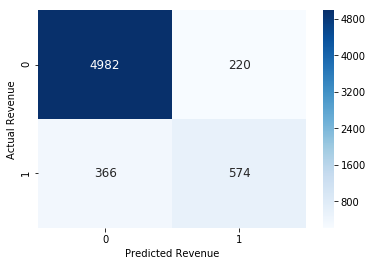

In [47]:
pred = final_pipeline.predict(X=X_test)
cm = confusion_matrix(y_true=y_test, y_pred=pred)
df_cm = pd.DataFrame(cm)
df_cm.index.name = 'Actual Revenue'
df_cm.columns.name = 'Predicted Revenue'
sns.heatmap(df_cm, cmap="Blues", annot=True, fmt='g', annot_kws={"size": 12});

# Deployment

In [20]:
wml_credentials={
  "url": "https://eu-gb.ml.cloud.ibm.com",
  "apikey": "jIs1rqQ818pgStOECwxmvhMxsWLyskFBzTHjfzWi76ET",
  "username": "Service credentials-1",
  "instance_id": "f45142b5-b178-444d-b30b-494230b95138"
}

client = WatsonMachineLearningAPIClient(wml_credentials)

In [21]:
model_props = {client.repository.ModelMetaNames.AUTHOR_NAME: "Tjark Petersen", 
               client.repository.ModelMetaNames.AUTHOR_EMAIL: "tjark.petersen@ibm.com", 
               client.repository.ModelMetaNames.NAME: "shopping_behaviour_final_model"}

model_artifact=client.repository.store_model(final_pipeline, meta_props=model_props, training_data=X_train, training_target=y_train)

In [22]:
#Get model UID
published_model_uid = client.repository.get_model_uid(model_artifact)
#Deploy the model
created_deployment = client.deployments.create(published_model_uid, name="shopping_behaviour_deployment")



#######################################################################################

Synchronous deployment creation for uid: '611dcfbf-c70e-4832-96f5-39d27fd8ef86' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9075c49c-a3f1-419f-8073-18e2a2a728d2'
------------------------------------------------------------------------------------------------




In [23]:
scoring_endpoint = client.deployments.get_scoring_url(created_deployment)
print(scoring_endpoint)

https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/f45142b5-b178-444d-b30b-494230b95138/deployments/9075c49c-a3f1-419f-8073-18e2a2a728d2/online


### Test the API:

In [27]:
# example input

example_values = [str(k) for k in X_test.iloc[25,:].values]
scoring_payload = {"fields": list(X_test.columns),"values":[example_values]}
predictions = client.deployments.score(scoring_endpoint, scoring_payload)
print(predictions)

{'fields': ['prediction', 'probability'], 'values': [[0, [0.5862835331496381, 0.41371646685036184]]]}


### Delete deployments if necessary

In [ ]:
client.deployments.list()

In [ ]:
client.repository.delete('- uid -')